# <center><span style="color:#0000ff"><u>Projet 6 - Analysez les ventes d'une librairie avec Python </u></span></center> 

## <center><span style="color:#0131b4"><u> I - Importation des librairies </u> </span></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import f_oneway

## <center><span style="color:#0131b4"><u>II - Importation des fichiers</u></span></center>

In [2]:
conso = pd.read_csv("customers.csv")
produit = pd.read_csv("products.csv")
transaction = pd.read_csv("transactions.csv")

## <center><span style="color:#0131b4"><u>III - Exploration des dataframes</u></span></center>

###  <center><span style="color:#2db4af"><u>1 - Visualisation du dataframe "Conso" </u></span></center>

In [3]:
conso

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [4]:
conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
conso.describe(include='all')

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [6]:
# Création d'une fonction à double usage :
# 1 - Vérification de l'unicité d'une colonne
# 2 - Indique si il y a des doublons dans la colonne ainsi que la quantité trouvée
def verifClePrimaireEtDoublons(df, colonne):
    """Fonction qui prend en entrée un dataframe et une colonne, vérifie si cette colonne est une clé primaire valide, détecte les doublons et renvoie les doublons s'il y en a"""
    valeurs_uniques = df[colonne].nunique()
    nombre_lignes = len(df)
    doublons = df[df.duplicated(subset=colonne, keep=False)]
    if valeurs_uniques == nombre_lignes:
        print(f"La colonne '{colonne}' est une clé primaire valide")
    else:
        print(f"La colonne '{colonne}' n'est pas une clé primaire valide")

    if len(doublons)>0:
        print(f"Il y a {len(doublons)} doublons dans la colonne '{colonne}'.")
        return doublons
    else:
        print(f"Il n'y a pas de doublons dans la colonne '{colonne}'.")
        return

In [7]:
verifClePrimaireEtDoublons(conso, "client_id")

La colonne 'client_id' est une clé primaire valide
Il n'y a pas de doublons dans la colonne 'client_id'.


In [8]:
#profile = ProfileReport(conso, minimal=True)
#profile.to_file("conso_v1.html")

###  <center><span style="color:#2db4af"><u>2 - Visualisation du dataframe "produit" </u></span></center>

In [9]:
produit

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


In [10]:
produit.info

<bound method DataFrame.info of      id_prod   price  categ
0     0_1421   19.99      0
1     0_1368    5.13      0
2      0_731   17.99      0
3      1_587    4.99      1
4     0_1507    3.99      0
...      ...     ...    ...
3282    2_23  115.99      2
3283   0_146   17.14      0
3284   0_802   11.22      0
3285   1_140   38.56      1
3286  0_1920   25.16      0

[3287 rows x 3 columns]>

In [11]:
produit.describe(include='all')

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [12]:
verifClePrimaireEtDoublons(produit, "id_prod")

La colonne 'id_prod' est une clé primaire valide
Il n'y a pas de doublons dans la colonne 'id_prod'.


In [13]:
#profile = ProfileReport(produit, minimal=True)
#profile.to_file("produit_v1.html")

###  <center><span style="color:#2db4af"><u>3 - Visualisation du dataframe "transaction" </u></span></center>

In [14]:
transaction

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


In [15]:
transaction.info

<bound method DataFrame.info of        id_prod                        date session_id client_id
0       0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1        1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2       0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3        2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4       0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232
...        ...                         ...        ...       ...
679527  0_1551  2022-01-15 13:05:06.246925   s_150195    c_8489
679528   1_639  2022-03-19 16:03:23.429229   s_181434    c_4370
679529  0_1425  2022-12-20 04:33:37.584749   s_314704     c_304
679530  0_1994  2021-07-16 20:36:35.350579    s_63204    c_2227
679531   1_523  2022-09-28 01:12:01.973763   s_274568    c_3873

[679532 rows x 4 columns]>

In [16]:
transaction.describe(include='all')

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [17]:
verifClePrimaireEtDoublons(transaction, "id_prod")

La colonne 'id_prod' n'est pas une clé primaire valide
Il y a 679514 doublons dans la colonne 'id_prod'.


,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


In [18]:
#profile = ProfileReport(transaction, minimal=True)
#profile.to_file("transaction_v1.html")

## <center><span style="color:#0131b4"><u>IV - Nettoyage des bases de données</u></span></center>

###  <center><span style="color:#2db4af"><u>1 - Recherche d'anomalies  </u></span></center>

In [19]:
#Découverte d'une valeure négative dans le df "produit"
produit.loc[produit.price<0]

,id_prod,price,categ
731,T_0,-1.0,0


In [20]:
#Affichage des id_prod "T_O" dans le df transaction
transaction.loc[transaction.id_prod=="T_0"]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [21]:
#Recherche d'information sur l'id client "ct_0"
conso.loc[conso.client_id=="ct_0"]

,client_id,sex,birth
2735,ct_0,f,2001


In [22]:
#Recherche d'information sur l'id client "ct_1"
conso.loc[conso.client_id=="ct_1"]

,client_id,sex,birth
8494,ct_1,m,2001


In [23]:
#Suppression du client test identifié avec l'id "T_0"
produit.drop(produit.loc[produit["id_prod"]=="T_0"].index, inplace = True)

In [24]:
#Suppression de l'id "T_0" appartenant au client test
transaction.drop(transaction.loc[transaction["id_prod"]=="T_0"].index, inplace = True)

In [25]:
#Suppression des id "ct_0" et "ct_1" appartenant au client test
conso.drop(conso[(conso["client_id"]=="ct_0") | (conso["client_id"]=="ct_1")].index, inplace = True)

####  <center><span style="color:#4c7e80"><u>1.1 - Vérification  </u></span></center>

In [26]:
produit.loc[produit.price<0]
transaction.loc[transaction.id_prod=="T_0"]

,id_prod,date,session_id,client_id


In [27]:
conso.loc[conso.client_id=="ct_0"]
conso.loc[conso.client_id=="ct_1"]

,client_id,sex,birth


###  <center><span style="color:#2db4af"><u>2 - Changement du format de la date  </u></span></center>

In [28]:
transaction["date"] = pd.to_datetime(transaction.date).dt.date

In [29]:
transaction["date"] = pd.to_datetime(transaction.date, format='%Y-%m-%d', errors = "coerce")

####  <center><span style="color:#4c7e80"><u>2.1 - Vérification  </u></span></center>

In [30]:
#Vérification des valeurs null crée avec la valeur "coerce"
transaction.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [31]:
transaction

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20,s_211425,c_103
1,1_251,2022-02-02,s_158752,c_8534
2,0_1277,2022-06-18,s_225667,c_6714
3,2_209,2021-06-24,s_52962,c_6941
4,0_1509,2023-01-11,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15,s_150195,c_8489
679528,1_639,2022-03-19,s_181434,c_4370
679529,0_1425,2022-12-20,s_314704,c_304
679530,0_1994,2021-07-16,s_63204,c_2227


###  <center><span style="color:#2db4af"><u>3 - Jointure et nettoyage  </u></span></center>

In [32]:
#jointure entre les dataframes
recap = transaction.merge(conso, how='left', on='client_id').merge(produit, how='left', on='id_prod', indicator = True)
recap

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge
0,0_1518,2022-05-20,s_211425,c_103,f,1986,4.18,0.0,both
1,1_251,2022-02-02,s_158752,c_8534,m,1988,15.99,1.0,both
2,0_1277,2022-06-18,s_225667,c_6714,f,1968,7.99,0.0,both
3,2_209,2021-06-24,s_52962,c_6941,m,2000,69.99,2.0,both
4,0_1509,2023-01-11,s_325227,c_4232,m,1980,4.99,0.0,both
...,...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15,s_150195,c_8489,f,1951,12.99,0.0,both
679328,1_639,2022-03-19,s_181434,c_4370,f,1977,10.99,1.0,both
679329,0_1425,2022-12-20,s_314704,c_304,f,1988,12.99,0.0,both
679330,0_1994,2021-07-16,s_63204,c_2227,m,1986,4.98,0.0,both


In [33]:
#profile = ProfileReport(recap, title="recap_v1")
#profile.to_widgets()

###  <center><span style="color:#2db4af"><u>3.1 - Gestion de l'id 0_2245  </u></span></center>

In [34]:
#Suppression de la colonne "_merge" 
del recap["_merge"]

In [35]:
#L'id 0_2245 ne fournit aucune informations dans les colonnes "price & categ"
recap.isnull().sum()

id_prod         0
date            0
session_id      0
client_id       0
sex             0
birth           0
price         221
categ         221
dtype: int64

####  <center><span style="color:#2db4af"><u>3.2 - Correction des valeurs null  </u></span></center>

In [36]:
#Le premier chiffre de l'id 0_2245 correspond à sa categorie (categ)
recap["categ"].fillna(value=0, inplace = True)

In [37]:
#ajout d'une médiane pour les valeurs null dans la colonne "price"
median = recap[recap["categ"] == 0]["price"].median()
recap["price"].fillna(value=median, inplace=True)
print(median)

9.99


In [38]:
#Vérification si la valeur 0_2245 est toujours présente
print(recap["categ"].isin(["0_2245"]).any())

False


In [39]:
recap.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
sex           0
birth         0
price         0
categ         0
dtype: int64

In [40]:
#Changement de la valeur "categ"
recap["categ"] = recap["categ"].astype(int)

In [41]:
recap

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1518,2022-05-20,s_211425,c_103,f,1986,4.18,0
1,1_251,2022-02-02,s_158752,c_8534,m,1988,15.99,1
2,0_1277,2022-06-18,s_225667,c_6714,f,1968,7.99,0
3,2_209,2021-06-24,s_52962,c_6941,m,2000,69.99,2
4,0_1509,2023-01-11,s_325227,c_4232,m,1980,4.99,0
...,...,...,...,...,...,...,...,...
679327,0_1551,2022-01-15,s_150195,c_8489,f,1951,12.99,0
679328,1_639,2022-03-19,s_181434,c_4370,f,1977,10.99,1
679329,0_1425,2022-12-20,s_314704,c_304,f,1988,12.99,0
679330,0_1994,2021-07-16,s_63204,c_2227,m,1986,4.98,0


###  <center><span style="color:#2db4af"><u>4 - Recherche de valeurs aberrantes  </u></span></center>

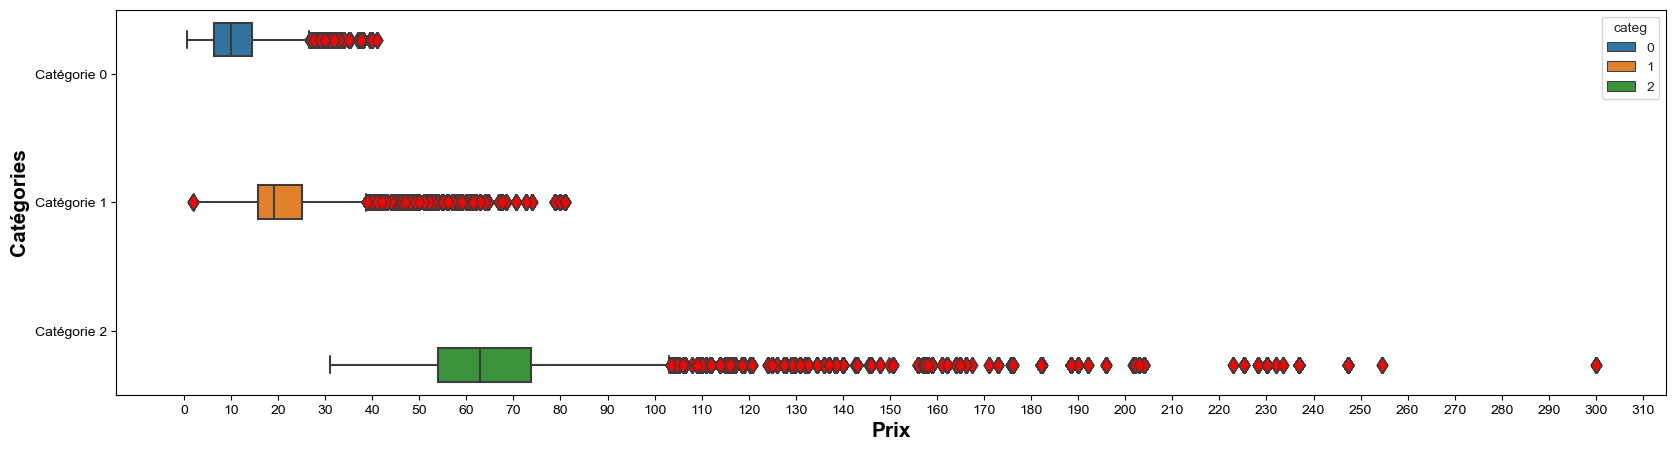

In [42]:
#Préparation des données pour le graphique
cat0 = recap[recap['categ'] == 0]['price']
cat1 = recap[recap['categ'] == 1]['price']
cat2 = recap[recap['categ'] == 2]['price']

#Paramètre d'affichage du graphique
plt.subplots(figsize=[20,5])
plt.xticks(np.arange(0, 350, 10))
sns.set_style('whitegrid')
sns.boxplot(x='price', y='categ', data=recap, hue='categ', orient='h', flierprops=dict(markerfacecolor='red', markersize=8))
plt.yticks(np.arange(3), ['Catégorie 0', 'Catégorie 1', 'Catégorie 2'])
plt.xlabel('Prix', weight='bold', size=15)
plt.ylabel('Catégories', weight='bold', size=15)
plt.show()

####  <center><span style="color:#2db4af"><u> 4.1 - Répartition par catégories  </u></span></center>

In [43]:
#Calcul des statistiques de chaque catégories
for i in range(3):
    cat = recap.loc[recap.categ == i]
    Q1 = round(cat.price.quantile(0.25), 2)
    Q3 = round(cat.price.quantile(0.75), 2)
    IQR = Q3 - Q1
    limite_inférieure = round(Q1 - 1.5*IQR,2)
    limite_supérieure = round(Q3 + 1.5*IQR,2)
    print(f"\nInformation pour la catégorie {i}:")
    print("Le premier quartile à une valeur de : {:.2f}".format(Q1))
    print("Le second quartile à une valeur de : {:.2f}".format(Q3))
    print(f"La valeur interquartile est de : {IQR}")
    print(f"La valeur aberrante inférieure est de : {limite_inférieure}")
    print(f"La valeur aberrante supérieure est de : {limite_supérieure}")


Information pour la catégorie 0:
Le premier quartile à une valeur de : 6.29
Le second quartile à une valeur de : 14.45
La valeur interquartile est de : 8.16
La valeur aberrante inférieure est de : -5.95
La valeur aberrante supérieure est de : 26.69

Information pour la catégorie 1:
Le premier quartile à une valeur de : 15.81
Le second quartile à une valeur de : 24.98
La valeur interquartile est de : 9.17
La valeur aberrante inférieure est de : 2.06
La valeur aberrante supérieure est de : 38.74

Information pour la catégorie 2:
Le premier quartile à une valeur de : 53.99
Le second quartile à une valeur de : 73.72
La valeur interquartile est de : 19.729999999999997
La valeur aberrante inférieure est de : 24.4
La valeur aberrante supérieure est de : 103.32


In [44]:
#Affichage des valeurs considérées comme aberrantes
recap[(recap.price>limite_supérieure) | (recap.price<limite_inférieure)].sort_values(by="price", ascending=False)

,id_prod,date,session_id,client_id,sex,birth,price,categ
638057,2_2,2021-03-07,s_3041,c_1001,m,1982,300.00,2
594923,2_2,2022-11-28,s_304241,c_659,f,2001,300.00,2
319823,2_2,2022-03-28,s_185980,c_659,f,2001,300.00,2
91228,2_2,2022-08-12,s_252144,c_5237,m,1999,300.00,2
181540,2_2,2021-12-07,s_130658,c_4958,m,1999,300.00,2
...,...,...,...,...,...,...,...,...
484095,0_528,2022-06-20,s_226722,c_7075,m,1988,0.62,0
291382,0_528,2021-06-20,s_51439,c_7075,m,1988,0.62,0
452042,0_202,2022-01-27,s_156085,c_7453,m,1986,0.62,0
612341,0_202,2022-01-06,s_145956,c_2069,m,1986,0.62,0


In [45]:
#Renommage des colonnes
recap.rename(columns={"id_prod":"produit", "session_id":"session", "client_id":"client", "sex":"sexe", "birth":"naissance", "price":"CA", "categ":"categorie"}, inplace=True)

In [46]:
#Création et réoganisation des colonnes
recap["date"] = pd.to_datetime(recap["date"])
recap["annee"] = recap["date"].dt.year
recap["mois"] = recap["date"].dt.month
recap["jour"] = recap["date"].dt.day
recap["annee_mois"] = recap["date"].dt.strftime("%Y-%m")
cols = ["produit", "jour", "mois", "annee","annee_mois", "date", "client", "sexe", "naissance", "session","categorie", "CA"]
recap = recap.reindex(columns=cols)

In [47]:
recap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679332 entries, 0 to 679331
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   produit     679332 non-null  object        
 1   jour        679332 non-null  int32         
 2   mois        679332 non-null  int32         
 3   annee       679332 non-null  int32         
 4   annee_mois  679332 non-null  object        
 5   date        679332 non-null  datetime64[ns]
 6   client      679332 non-null  object        
 7   sexe        679332 non-null  object        
 8   naissance   679332 non-null  int64         
 9   session     679332 non-null  object        
 10  categorie   679332 non-null  int32         
 11  CA          679332 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(5)
memory usage: 51.8+ MB


TypeError: datetime64 type does not support sum operations

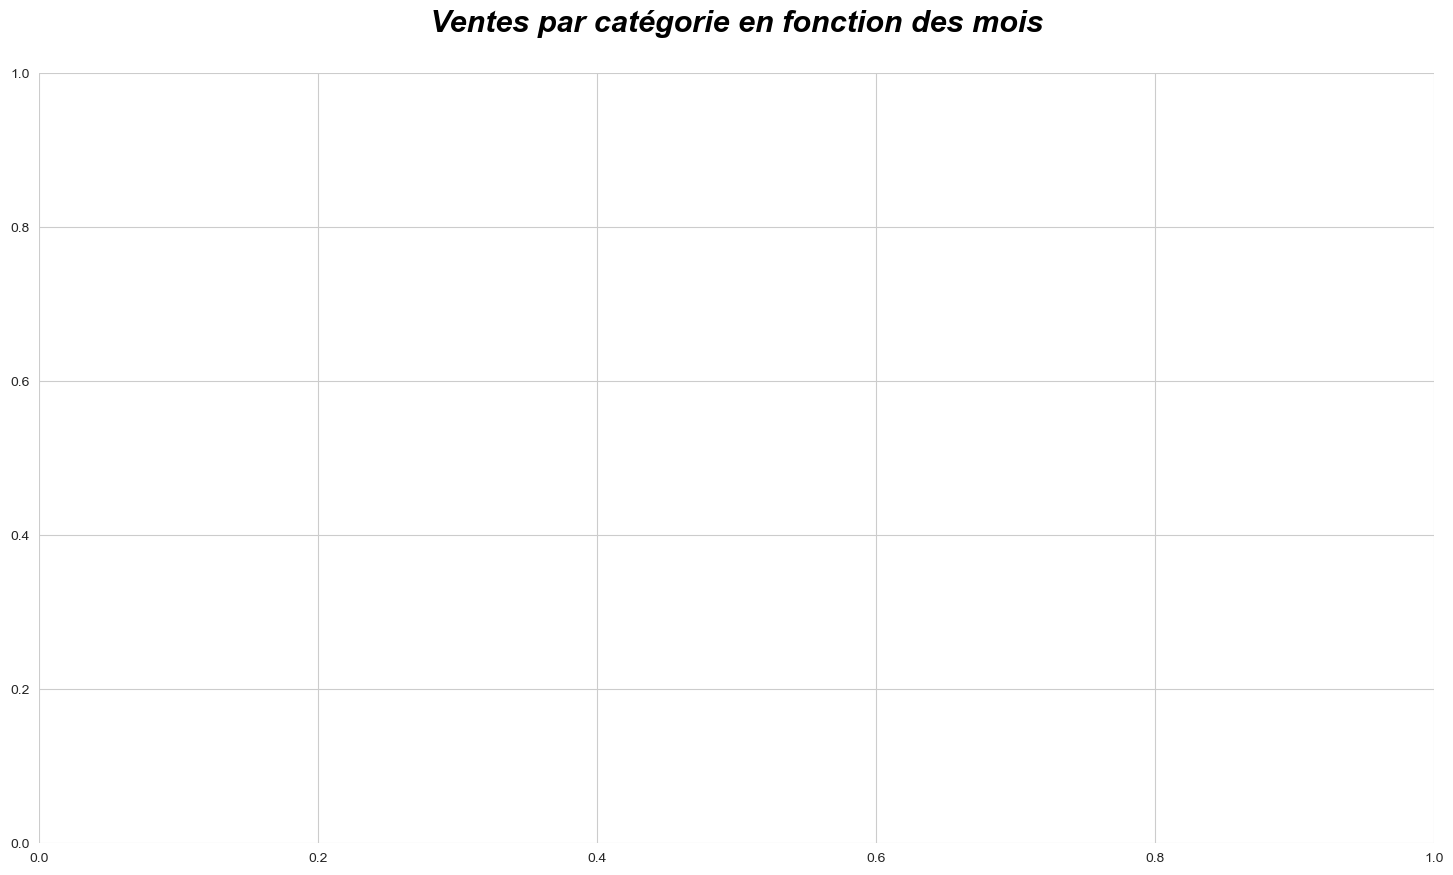

In [48]:
#Affichage des ventes avec indicateur des catégories
fig,ax =plt.subplots(figsize=(18,10))
ax.set_title("Ventes par catégorie en fonction des mois",
    fontsize=22,weight="bold",color="Black", style="italic",loc="center",pad=30)
plt.box(False)

ca_mensuel = recap.groupby(["annee_mois","categorie"]).sum().unstack().plot(kind='bar', 
            y = 'CA',  ax=ax, stacked=True, figsize = (18,10), 
            color=["blue", "orange", "green"])
plt.legend(('Catégorie 0', 'Catégorie 1','Catégorie 2'), loc="upper center", fontsize=16)

plt.ylabel("CHIFFRE D'AFFAIRES", weight='bold', size=15)
plt.xlabel("MOIS", weight='bold', size=15)
plt.yticks(np.arange(0, 750000, 50000), fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [ ]:
#Observation du mois d'octobre 2021
graph_ca_oct21 = recap.groupby(["date","categorie"])["CA"].sum().reset_index()
mask_graph_oct21 =(graph_ca_oct21["date"]>="2021-10-1") & (graph_ca_oct21["date"]<="2021-10-31")
graph_ca_oct21 = graph_ca_oct21.loc[mask_graph_oct21]
graph_ca_oct21["date"] = graph_ca_oct21["date"].astype(str)

In [ ]:
#Affichage en graphique du chiffre d'affaire pour le mois d'octobre 2021
fig,ax =plt.subplots(figsize=(18,10))
ax.set_title("CA par catégorie - Octobre 2021",
    fontsize=22,weight="bold",color="Black", style="italic",loc="center",pad=30)
plt.box(False)

graph_ca_oct21.groupby(['date','categorie']).sum().unstack().plot(kind='bar', 
            y = 'CA',  ax=ax, stacked=True, figsize = (18,10), 
            color=['blue', 'orange', 'green'])
plt.legend(('Catégorie 0', 'Catégorie 1','Catégorie 2'), loc="upper center", fontsize=16)

plt.ylabel("CHIFFRE D'AFFAIRES", weight='bold', size=15)
plt.xlabel("JOURS", weight='bold', size=15)
plt.yticks(np.arange(0, 19000, 1500), fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [ ]:
recap["date"] = pd.to_datetime(recap["date"])
octobre21 = recap.loc[(recap["date"] >= "2021-10-01") & (recap["date"] <= "2021-10-31")]
octobre21

In [ ]:
#Analyse des données sur le mois d'octobre 2021
#profile = ProfileReport(graph_ca_oct21, title="oct21_v1")
#profile.to_widgets()

In [ ]:
#Nombre de transactions
total_session = recap["session"].count()
print(f"Il y a eu {total_session} transactions")

In [ ]:
#Chiffre d'affaires total
total_ca = recap["CA"].sum()
print(f"repésentant un Chiffre d'affaire total de {total_ca:,} €")

In [ ]:
#Suppression des jours du mois d'octobre représentant une anomalie
recap = recap[(recap["date"] < "2021-10-02") | (recap["date"] > "2021-10-27")]

In [ ]:
#Nombre de transactions
total_session = recap["session"].count()
print(f"Il y a eu {total_session} transactions")

In [ ]:
#Chiffre d'affaires total
total_ca = recap["CA"].sum()
print(f"repésentant un Chiffre d'affaire total de {total_ca:,} €")

In [ ]:
#Observation du mois d'octobre 2021
graph_ca_oct21b = recap.groupby(["date","categorie"])["CA"].sum().reset_index()
mask_graph_oct21b =(graph_ca_oct21b["date"]>="2021-10-1") & (graph_ca_oct21b["date"]<="2021-10-31")
graph_ca_oct21b = graph_ca_oct21b.loc[mask_graph_oct21b]
graph_ca_oct21b["date"] = graph_ca_oct21b["date"].astype(str)

#Affichage en graphique du chiffre d'affaire pour le mois d'octobre 2021
fig,ax =plt.subplots(figsize=(18,10))
ax.set_title("CA par catégorie - Octobre 2021",
    fontsize=22,weight="bold",color="Black", style="italic",loc="center",pad=30)
plt.box(False)

graph_ca_oct21b.groupby(['date','categorie']).sum().unstack().plot(kind='bar', 
            y = 'CA',  ax=ax, stacked=True, figsize = (18,10), 
            color=['blue', 'orange', 'green'])
plt.legend(('Catégorie 0', 'Catégorie 1','Catégorie 2'), loc="upper center", fontsize=16)

plt.ylabel("CHIFFRE D'AFFAIRES", weight='bold', size=15)
plt.xlabel("JOURS", weight='bold', size=15)
plt.yticks(np.arange(0, 19000, 1500), fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.show()

###  <center><span style="color:#2db4af"><u>Préparation de variables utiles pour l'analyse</u></span></center>

In [ ]:
#CA par clients
ca_par_client = recap.groupby("client")["CA"].sum()

#CA par Produits
ca_par_produit = recap.groupby("produit")["CA"].sum()

#Nombre de produits vendu par client
nb_pdt_par_client = recap.groupby("client")["produit"].count()

#Nombre de produits vendus par produits
nb_pdt_par_pdt = recap.groupby('produit')['client'].count()

#Chiffre d'affaires moyen par client
ca_moy_par_client = recap.groupby("client")["CA"].mean()

#Chiffre d'affaires moyen par produit
ca_moy_par_pdt = recap.groupby("client")["CA"].mean()

#Chiffre d'affaire moyen par catégorie
ca_moy_par_cat = recap.groupby('categorie')['CA'].mean()

#Chiffre d'affaires total par client
ca_tt_client = recap.groupby("client")["CA"].max()

#Chiffre d'affaires total par produit
ca_tt_par_pdt = recap.groupby("produit")["CA"].max()

#Chiffre d'affaires minimal par clients
ca_min_par_client = recap.groupby('client')['CA'].min()

#Chiffre d'affaires minimal par produits
ca_min_par_produit = recap.groupby('produit')['CA'].min()

#Chiffre d'affaires total par jour
ca_tt_jour = recap.groupby('date')['CA'].sum()

#Chiffre d'affaires total par semaine
recap['semaine'] = recap['date'].dt.week
ca_tt_hebdo = recap.groupby('semaine')['CA'].sum()

#Chiffre d'affaires total par mois
ca_total_mois = recap.groupby('annee_mois')['CA'].sum()

#Chiffre d'affaires total par année
ca_total_année = recap.groupby('annee')['CA'].sum()

#ajout de l'année pour les calculs des ages
current_year = 2023
recap['age'] = current_year - recap['naissance']

<hr>

---

## <center><span style="color:#0131b4"><u>Les Questions</u></span></center>

##  <center><span style="color:grey"><u>Antoine / Annabelle</u></span></center>

###  <center><span style="color:#2db4af"><u>Revue du chiffre d'affaire</u></span></center>

####  <center><span style="color:#008080"><u>Vue du CA par semaine</u></span></center>

In [ ]:
#Agrégation des données par semaine
ca_semaine = recap.groupby(['annee', 'semaine'])['CA'].sum().reset_index()

#Création du graphique
fig, ax = plt.subplots(figsize=(15, 6))

#Graphique du chiffre d'affaires par semaine
sns.lineplot(x='semaine', y='CA', hue='annee', data=ca_semaine)
plt.title('Chiffre d\'affaires par semaine')
plt.xlabel('Semaine')
plt.ylabel('Chiffre d\'affaires')
ax.set_xticks(range(0, 53))

plt.show()

###### Nous disposons des informations de mars à décembre pour 2021 et janvier et février pour 2023. Seul l'année 2022 est complète

####  <center><span style="color:#008080"><u>Vue du CA par mois</u></span></center>

In [ ]:
ca_mois = recap.groupby('annee_mois')['CA'].sum()

fig = plt.figure(figsize=(15, 6))
plt.plot(ca_mois.index, ca_mois.values)
plt.title('Chiffre d\'affaires par mois')
plt.xlabel('Mois')
plt.ylabel('Chiffre d\'affaires')
plt.xticks(rotation=90, fontsize=12)
plt.show()

####  <center><span style="color:#008080"><u>Apercu du CA pour la catégorie 0</u></span></center>

In [ ]:
#Affichage du CA pour la cat 0
cat_0 = recap[recap["categorie"] == 0]
ca_0 = cat_0.groupby("annee_mois")["CA"].sum()
plt.figure(figsize=(15, 5))
plt.plot(ca_0.index, ca_0.values, color="blue", label="Catégorie 0")
plt.title("Evolution du chiffre d'affaire de la catégorie 0")
plt.legend()
plt.xticks(rotation=90, fontsize=12)
plt.show()

####  <center><span style="color:#008080"><u>Apercu du CA pour la catégorie 1</u></span></center>

In [ ]:
#Affichage du CA pour la cat 1
cat_1 = recap[recap["categorie"] == 1]
ca_1 = cat_1.groupby("annee_mois")["CA"].sum()
plt.figure(figsize=(15, 5))
plt.plot(ca_1.index, ca_1.values, color="orange", label="Catégorie 1")
plt.title("Evolution du chiffre d'affaire de la catégorie 1")
plt.legend()
plt.xticks(rotation=90, fontsize=12)
plt.show()

####  <center><span style="color:#008080"><u>Apercu du CA pour la catégorie 2</u></span></center>

In [ ]:
#Affichage du CA pour la cat 2
cat_2 = recap[recap["categorie"] == 2]
ca_2 = cat_2.groupby("annee_mois")["CA"].sum()
plt.figure(figsize=(15, 5))
plt.plot(ca_2.index, ca_2.values, color="green", label="Catégorie 2")
plt.title("Evolution du chiffre d'affaire de la catégorie 2")
plt.legend()
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [ ]:
#Evolution de CA dans le temps
evo_ca0 = ca_0.diff()
evo_ca1 = ca_1.diff()
evo_ca2 = ca_2.diff()
plt.figure(figsize=(15, 5))
plt.plot(evo_ca0.index, evo_ca0.values)
plt.plot(evo_ca1.index, evo_ca1.values)
plt.plot(evo_ca2.index, evo_ca2.values)
plt.title("Evolution du chiffre d'affaire dans le temps")
plt.xlabel("mois")
plt.ylabel("Variation du chiffre d'affaire")
plt.xticks(rotation=90, fontsize=12)
plt.legend(["categorie 0", "categorie 1", "categorie 2"])
plt.show()

###  <center><span style="color:#2db4af"><u>Evolution dans le temps avec moyenne mobile</u></span></center>

###### <span style="color:#8a2be2">La décomposition en moyenne mobile est une méthode utilisée en statistiques pour comprendre comment une série de données évolue au fil du temps. Cette méthode consiste à diviser la série de données en plusieurs composantes, telles que la tendance, la saisonnalité et les fluctuations aléatoires.</span>

###### <span style="color:#8a2be2">La moyenne mobile est une technique utilisée en analyse de données pour lisser les fluctuations aléatoires d'une série temporelle. Cette technique implique de prendre la moyenne des données d'une série temporelle sur une période spécifique, puis de faire glisser cette période dans le temps pour produire une série de valeurs lissées. La moyenne mobile peut aider à mettre en évidence des tendances à long terme dans une série temporelle en réduisant le bruit et les fluctuations aléatoires. Les moyennes mobiles sont souvent utilisées pour l'analyse de données financières, l'analyse économique, la prévision de la demande et d'autres applications où il est important d'identifier les tendances et les modèles dans les données temporelles.</span>

In [ ]:
recap.sort_values('date', inplace=True)
df = pd.pivot_table(recap, values='CA', index='date', aggfunc='sum')
df['rolling_mean'] = df['CA'].rolling(window=7).mean()
df['rolling_mean'].fillna(df['rolling_mean'].mean(), inplace=True)
result = seasonal_decompose(df['rolling_mean'], model='additive', period=7)

In [ ]:
fig = result.observed.plot(title='Série chronologique originale', color='blue', ylabel='CA en euros', fontsize=14, figsize=(15, 6))
display(fig)

###### Ce graphique représente la série chronologique originale, avec toutes ses variations saisonnières, tendances et résiduelles. Il permet de voir comment la série chronologique évolue sur l'ensemble de la période, avec toutes les fluctuations à court terme, les variations saisonnières et les tendances à long terme.

In [ ]:
fig = result.trend.plot(title='Tendance', color='green', ylabel='CA en euros', fontsize=14, figsize=(15, 6))
display(fig)

###### Ce graphique représente la tendance de la série chronologique. Il montre comment la série chronologique évolue sur une longue période de temps, sans les variations saisonnières ou les fluctuations à court terme. La tendance peut être croissante, décroissante ou plate.

In [ ]:
fig = result.resid.plot(title='Résidus', color='red', ylabel='CA en euros', fontsize=14, figsize=(15, 6))
display(fig)

###### Ce graphique représente les résidus de la série chronologique. Les résidus sont les différences entre la série chronologique et la somme de sa tendance et de sa saisonnalité. Ils reflètent les variations aléatoires de la série chronologique qui ne peuvent pas être expliquées par la tendance ou la saisonnalité.

###### <span style="color:#8a2be2">La méthode de décomposition en moyenne mobile utilise des moyennes mobiles pour estimer les différentes composantes de la série de données. En utilisant cette méthode, il est possible de séparer les différentes tendances et les différentes saisons dans une série de données et d'identifier les fluctuations aléatoires qui ne peuvent pas être expliquées par ces tendances et saisons. Cela permet de mieux comprendre les motifs et les tendances dans les données et d'effectuer des prévisions plus précises.</span>

In [ ]:
#Graphique de la moyenne mobile
fig, ax = plt.subplots(figsize=[15,10])

#Chiffre d'affaire
ax.plot(df.index, df['CA'], color='cyan', linewidth=1)

#Moyenne mobile
ax.plot(df.index, df['rolling_mean'], color='purple', linewidth=2)

#Axe et legende du graphique
ax.legend(labels=["Chiffre d'affaire","Moyenne mobile"])
ax.set_title("Décomposition moyenne mobile")
ax.set_yticks(np.arange(13000, 20500, 500))
ax.set_xlabel("Date")
ax.set_ylabel("Chiffre d'affaires en euros")
plt.xticks(rotation=45, fontsize=12)

#Affichage
plt.show()

###### La ligne cyan représente le chiffre d'affaires réel de l'entreprise, tandis que la ligne violette représente la moyenne mobile, la moyenne des chiffres d'affaires.

###  <center><span style="color:#2db4af"><u>Zoom sur les références</u></span></center>

####  <center><span style="color:#008080"><u>Apercu global</u></span></center>

In [ ]:
#Préparation des données pour chaque catégorie de produit
cat_0 = recap[recap["produit"].str.startswith("0_")]["CA"].values
cat_1 = recap[recap["produit"].str.startswith("1_")]["CA"].values
cat_2 = recap[recap["produit"].str.startswith("2_")]["CA"].values

#Affichage du graphique
fig, ax = plt.subplots(figsize=(18, 8))
plt.boxplot([cat_0, cat_1, cat_2], vert=False)
plt.yticks([1, 2, 3], ["Catégorie 0_xxxxx", "Catégorie 1_xxxxx", "Catégorie 2_xxxxx"])
plt.xlabel("Valeurs en euros")
plt.title("Ventes par catégorie de produit")
ax.set_xticks(range(0, 320, 5))
ax.set_xlim(0, 320)
plt.xticks(rotation=90, fontsize=12)
plt.show()

####  <center><span style="color:#008080"><u>Top / Flop global</u></span></center>

In [ ]:
#Le Top 10
top_10_pdt = recap.groupby("produit")["CA"].sum().sort_values(ascending=False)
print(f"Top 10 des produits par CA :\n{top_10_pdt.head(10)}")

In [ ]:
#Le Flop 10
supp_2245 = recap[recap["produit"] == "0_2245"].index
recap = recap.drop(supp_2245)
flop_10_pdt = recap.groupby("produit")["CA"].sum().sort_values(ascending=True)
print(f"flop 10 des produits par CA :\n{flop_10_pdt.head(10)}")

####  <center><span style="color:#008080"><u>Top / Flop par catégories</u></span></center>

In [ ]:
#Classement des Top 5 et flop pour la catégorie de produit 0
cat_0_sales = recap[recap["produit"].str.startswith("0_")]
cat_0_top_5 = cat_0_sales.groupby("produit")["CA"].sum().sort_values(ascending=False).head(5)
cat_0_flop_5 = cat_0_sales.groupby("produit")["CA"].sum().sort_values(ascending=True).head(5)

#Classement des Top 5 et flop pour la catégorie de produit 1
cat_1_sales = recap[recap["produit"].str.startswith("1_")]
cat_1_top_5 = cat_1_sales.groupby("produit")["CA"].sum().sort_values(ascending=False).head(5)
cat_1_flop_5 = cat_1_sales.groupby("produit")["CA"].sum().sort_values(ascending=True).head(5)

#Classement des Top 5 et flop pour la catégorie de produit 2
cat_2_sales = recap[recap["produit"].str.startswith("2_")]
cat_2_top_5 = cat_2_sales.groupby("produit")["CA"].sum().sort_values(ascending=False).head(5)
cat_2_flop_5 = cat_2_sales.groupby("produit")["CA"].sum().sort_values(ascending=True).head(5)

In [ ]:
print("Top 5 pour la catégorie 0 : ")
print(cat_0_top_5)
print("Flop pour la catégorie 0 : ")
print(cat_0_flop_5)

In [ ]:
print("Top 5 pour la catégorie 1 : ")
print(cat_1_top_5)
print("Flop pour la catégorie 1 : ")
print(cat_1_flop_5)

In [ ]:
print("Top 5 pour la catégorie 2 : ")
print(cat_2_top_5)
print("Flop pour la catégorie 2 : ")
print(cat_2_flop_5)

####  <center><span style="color:#008080"><u>Répartition du CA par catégorie de produit</u></span></center>

In [ ]:
#Liste des catégories
categories = [0, 1, 2]
ca_categories = []

#Calcul du CA des catégories
for cat in categories:
    ca_cat = recap[recap['categorie'] == cat]['CA'].sum()
    ca_categories.append(ca_cat)

#Affichage du graphique
plt.bar(range(len(categories)), ca_categories)
plt.title("Répartition du chiffre d'affaires par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(range(len(categories)), categories)
plt.show()

###  <center><span style="color:#2db4af"><u>Profils des clients</u></span></center>

####  <center><span style="color:#008080"><u>Répartition du chiffre d'affaire par groupe d'âge</u></span></center>

In [ ]:
#Calcul de l'age des clients
bins=[-1, 19, 29, 39, 49, 59, 69, 79, 89, 99]
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
recap['age_grp'] = pd.cut(2023 - recap['naissance'], bins=bins, labels=labels)

#Regroupement par age pour le calcul du CA
ca_age = recap.groupby('age_grp')['CA'].sum().reset_index()

#Affichage du graphique
plt.figure(figsize=(15, 8))
sns.barplot(x='age_grp', y='CA', data=ca_age, palette='pastel')
plt.title("Répartition du chiffre d'affaires par groupe d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Chiffre d'affaires (en euros)")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=90, fontsize=12)
plt.show()

####  <center><span style="color:#008080"><u>Répartition du chiffre d'affaire par genre</u></span></center>

In [ ]:
#Sélection des données
ca_fem = recap[recap["sexe"] == "f"]["CA"]
ca_masc = recap[recap["sexe"] == "m"]["CA"]

#Création du graphique
sns.set(style="whitegrid")
sns.boxplot(x="sexe", y="CA", data=recap)
sns.violinplot(x="sexe", y="CA", data=recap, color=".8")

#labels et affichage du graphique
plt.xlabel("Sexe")
plt.ylabel("Chiffre d'affaires")
plt.title("Comparaison des chiffres d'affaires par sexe")
plt.show()

In [ ]:
#Reroupement par genre et calcul du CA
ca_sexe = recap.groupby('sexe')['CA'].sum().reset_index()

#Affichage du graphique
labels = ca_sexe['sexe']
sizes = ca_sexe['CA']
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Répartition du chiffre d\'affaires par genre')
plt.axis('equal')
plt.show()

#Montant total du CA
print(f"Le chiffre d'affaire par genre :\n {ca_sexe}")

####  <center><span style="color:#008080"><u>Affichage de la courbes de Lorenz</u></span></center>

###### <span style="color:#8a2be2">La courbe de Lorenz est un graphique utilisé en économie pour représenter la distribution de la richesse ou du revenu au sein d'une population. Elle montre la proportion cumulée de la richesse ou du revenu détenu par les différentes tranches de la population, en partant de la tranche la plus pauvre jusqu'à la tranche la plus riche. La courbe de Lorenz permet de visualiser facilement la répartition de la richesse ou du revenu dans une population donnée et d'évaluer la mesure de l'inégalité de cette distribution. Plus la courbe de Lorenz s'éloigne de la ligne de parfaite égalité, plus l'inégalité est grande.</span>

In [ ]:
#Calcul du chiffre d'affaires total par client
ca_par_client = recap.groupby('client')['CA'].sum()

#Calcul de la part du chiffre d'affaires réalisée par chaque client
part_ca_par_client = ca_par_client / ca_par_client.sum()

#Triage des parts du chiffre d'affaires par ordre décroissant
part_ca_par_client_triees = part_ca_par_client.sort_values(ascending=False)

#Calcul de la courbe de Lorenz
cumul_part_ca_par_client = np.cumsum(part_ca_par_client_triees)
cumul_ca_par_client = np.cumsum(ca_par_client[part_ca_par_client_triees.index])
lorenz_curve_clients = cumul_ca_par_client / cumul_ca_par_client.max()

#Calcul de l'indice de Gini
ecart_type = np.linspace(0,1,len(lorenz_curve_clients))
indices = np.trapz(lorenz_curve_clients, ecart_type)
indice_gini = (indices - 0.5) / 0.5

#Courbe de Lorenz
plt.plot([0,1], [0,1], color='grey', linestyle='--', label='Répartition équitable')
plt.plot(np.linspace(0,1,len(lorenz_curve_clients)), lorenz_curve_clients, label='Courbe de Lorenz')
plt.title("Courbe de Lorenz avec part des client et du CA")
plt.xlabel("Part des clients")
plt.ylabel("Part du chiffre d'affaires")
plt.legend()

#Affichage de l'indice de Gini
plt.text(0.4, 0.2, f'Indice de Gini : {indice_gini:.2f}', fontsize=12)
plt.text(0.4, 0.15, "La répartition des clients est inéquitable")
plt.show()

###### la répartition des clients est inéquitable, ce qui est confirmé par l'indice de Gini de 0,45. Cela signifie qu'une petite proportion de clients génère une grande partie du chiffre d'affaires, tandis qu'une grande proportion de clients ne génère qu'une petite partie du chiffre d'affaires.

In [ ]:
#Calcul du chiffre d'affaires total par client
ca_par_client = recap.groupby('client')['CA'].sum()

#Calcul de la part du chiffre d'affaires réalisée par chaque client
part_ca_par_client = ca_par_client / ca_par_client.sum()

#Triage des parts du chiffre d'affaires par ordre décroissant
part_ca_par_client_triees = part_ca_par_client.sort_values(ascending=False)

#Calcul de la courbe de Lorenz
cumul_part_ca_par_client = np.cumsum(part_ca_par_client_triees)
cumul_ca_par_client = np.cumsum(ca_par_client[part_ca_par_client_triees.index])
lorenz_curve_clients = cumul_ca_par_client / cumul_ca_par_client.max()

#Tracé de la courbe de Lorenz
fig, ax = plt.subplots()
ax.plot(lorenz_curve_clients, np.linspace(0,1,len(lorenz_curve_clients)))
ax.plot([0,1], [0,1], color='grey', linestyle='--')
ax.set(title="Courbe de Lorenz des clients",
xlabel="Part du chiffre d'affaires",
ylabel="Part des clients")
plt.show()

###### On peut voir que les 20% des clients qui réalisent les ventes les plus élevées représentent environ 50% du chiffre d'affaires total, tandis que les 80% des clients restants représentent environ 50% du chiffre d'affaires.

In [ ]:
#Calculer du CA par client
ca_par_client = recap.groupby("client")["CA"].sum()

#Classement des 25 clients ayant le plus de CA
clients_top = ca_par_client.sort_values(ascending=False).head(25)

#Affichage du graphique
plt.figure(figsize=(7,5))
sns.barplot(x=clients_top.values, y=clients_top.index, palette='magma')
plt.title("Part du CA par client", fontsize=15, fontweight='bold')
plt.ylabel("Client", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

##  <center><span style="color:grey"><u>Julie</u></span></center>

####  <center><span style="color:#008080"><u>Lien entre le genre d'un client et les catégories </u></span></center>

In [ ]:
#Regroupement des données par catégorie et genre
grouped = recap.groupby(['categorie', 'sexe']).size().reset_index(name='count')

#Affichage du graphique
sns.set(style='whitegrid')
sns.barplot(x='categorie', y='count', hue='sexe', data=grouped)
plt.title('Répartition des clients par catégorie et genre')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de clients')
plt.show()

###### Les hommes achète d'avantage de produit dans les catégorie 0 et 2 tandis que les femmes sont plus adèpte de produit de la catégorie 1

####  <center><span style="color:#008080"><u>Lien entre l'age des clients</u></span></center>

In [ ]:
#Création d'un sous-ensemble de données avec les colonnes 'age' et 'sexe'
data = recap[['age', 'sexe']]

#Création de deux sous-ensembles de données pour chaque sexe
data_f = data[data['sexe'] == 'f']
data_m = data[data['sexe'] == 'm']

#Création d'un histogramme pour chaque sexe
plt.hist(data_f['age'], bins=10, alpha=0.5, label='Femme')
plt.hist(data_m['age'], bins=10, alpha=0.5, label='Homme')

#Titre et legende du graphique
plt.title("Répartition des âges par sexe")
plt.xlabel("Âge")
plt.ylabel("Nombre d'individus")
plt.legend(loc='upper right')
plt.show()

####  <center><span style="color:#008080"><u>Montant et répartition des achats par tranches d'age</u></span></center>

In [ ]:
#Préparation des données
recap['naissance'] = pd.to_datetime(recap['naissance'], format='%Y')
now = datetime.now().year
recap['age'] = now - recap['naissance'].dt.year

#Préparetion des groupes d'ages
age_bins = [i for i in range(0, 101, 10)]
age_labels = [f"{i}-{i+9}" for i in range(0, 100, 10)]
recap['age_group'] = pd.cut(recap['age'], bins=age_bins, labels=age_labels)
cat_par_age = recap.groupby(['age_group', 'categorie'])['produit'].count().unstack()

#Affichage du graphique
ax = cat_par_age.plot(kind='bar', stacked=True)
ax.set_xticklabels(age_labels, rotation=0)
plt.ylim(0, 225000)
plt.title("Nombre de produits achetés par tranche d'âge et par catégorie de produit")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre de produits achetés")
plt.legend(title='Catégorie')
plt.show()

####  <center><span style="color:#008080"><u>Répartition du panier moyen par groupe d'âge</u></span></center>

In [ ]:
#Calcul du panier moyen par groupe d'âge
panier_moyen_age = recap.groupby('age_grp')['CA'].mean().reset_index()

#Affichage du graphique
plt.figure(figsize=(15, 8))
sns.barplot(x='age_grp', y='CA', data=panier_moyen_age, palette='pastel')
plt.title("Panier moyen par groupe d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Panier moyen (en euros)")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=90, fontsize=12)
plt.show()

####  <center><span style="color:#008080"><u>Montant et répartition des achats par tranches d'age</u></span></center>

In [ ]:
#Préparation des données
recap['naissance'] = pd.to_datetime(recap['naissance'], format='%Y')
now = datetime.now().year
recap['age'] = now - recap['naissance'].dt.year

#Préparation des groupes d'ages
age_bins = [i for i in range(0, 101, 10)]
age_labels = [f"{i}-{i+9}" for i in range(0, 100, 10)]
recap['age_group'] = pd.cut(recap['age'], bins=age_bins, labels=age_labels)
freq_achat_par_age = recap.groupby(['age_group'])['session'].nunique()

#Affichage du graphique
plt.figure(figsize=(15, 6))
ax = freq_achat_par_age.plot(kind='bar', color="navy")
ax.set_xticklabels(age_labels, rotation=0)
plt.ylim(0, 100000)
plt.title("Fréquence d'achat par tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre de sessions d'achat")
plt.show()

####  <center><span style="color:#008080"><u>Tests supplémentaire</u></span></center>

## Test du χ²

###### <span style="color:#8a2be2">Le test du Chi-carré (χ², chi2, chi deux) est une méthode statistique utilisée pour déterminer si deux variables catégorielles sont indépendantes ou non. Il compare les fréquences observées des variables à celles qui seraient attendues si les variables étaient indépendantes. Si les fréquences observées sont significativement différentes des fréquences attendues, cela indique que les variables ne sont pas indépendantes. Le test du Chi-carré est souvent utilisé dans les enquêtes d'opinion, les études de marché, la sociologie et d'autres domaines où il est nécessaire de déterminer s'il existe une relation entre deux variables nominales ou ordinales. Il peut également être utilisé pour comparer les fréquences de différentes catégories dans une seule variable.</span>

In [ ]:
#Tableau de contingence entre la catégorie et le sexe des clients
contingence_table = pd.crosstab(recap['categorie'], recap['sexe'])

#Calcul du chi2 et de la p-value
chi2, p, dof, expected = chi2_contingency(contingence_table)

#Création du graphique en heatmap
sns.heatmap(contingence_table, annot=True, fmt='d', cmap='Blues')

#Ajout des légendes du graphique
plt.title("Tableau de contingence catégorie/genre\nChi2 = {:.2f}, p = {:.3f}".format(chi2, p))
plt.xlabel("Genre")
plt.ylabel("Catégorie")
plt.show()

###### Le graphique montre les catégories de clients en fonction du sexe des clients. On peut constater que la catégorie 0 est majoritairement représentée par les femmes par rapport aux autre catégorie ou elle ce situe. Il y a plus d'homme que de femme dans la catégorie 2. La catégorie 1 est relativement bien répartie entre les sexes masculin et féminin.

###### Chi2 = 139.96 Cette valeur de test indique que la relation entre les variables "catégorie des clients" et "sexe des clients" est statistiquement significative.

###### p-value = 0.000 Cette valeur signifie que la probabilité d'obtenir un tel résultat par hasard est très faible (inférieure à 0,001), ce qui renforce la conclusion que la relation entre les variables est significative.

## Test de Pearson

###### <span style="color:#8a2be2">Le test de corrélation de Pearson, également appelé coefficient de corrélation de Pearson, est utilisé pour mesurer la relation linéaire entre deux variables continues. Il calcule un coefficient de corrélation, noté r, qui varie de -1 à 1. Si le coefficient est proche de -1, cela indique une corrélation négative forte, tandis qu'un coefficient proche de 1 indique une corrélation positive forte. Un coefficient proche de 0 indique une faible corrélation. Le test de corrélation de Pearson est souvent utilisé dans les domaines de la psychologie, de la sociologie, de l'économie, des sciences de la santé et d'autres domaines où la relation entre deux variables doit être mesurée.</span>

In [ ]:
#Préparation des données
recap['naissance'] = pd.to_datetime(recap['naissance'], format='%Y')
recap['Birth Pearson'] = recap['naissance'].dt.year.astype(int)
y = recap['CA']
x = recap['Birth Pearson']
corr, p_value = pearsonr(x, y)

#Analyse des résultats du Test
print("Coefficient de corrélation :", corr)
print("Valeur p :", round(p_value, 4))

#Affichage du graphique
plt.figure(figsize=(15, 6))
sns.regplot(x=x, y=y, color='red', line_kws={'color': 'blue'})
plt.title("Test de Pearson entre l'âge et CA")
plt.xlabel("Année de naissance")
plt.ylabel("Chiffre d'affaires")
plt.show()

###### Le coefficient de corrélation indique qu'il y a une faible corrélation positive entre l'année de naissance des clients et le  chiffre d'affaires de la librairie. Cela signifie que les clients plus âgés ne sont pas nécessairement plus susceptibles de    dépenser plus d'argent que les clients plus jeunes, mais qu'il y a une tendance générale à mesure que l'âge augmente.

###### La valeur p suggère qu'il est très peu probable que la corrélation observée entre l'année de naissance des clients et le      chiffre d'affaires soit due au hasard. Cela suggère qu'il existe une relation significative entre ces deux variables.

In [ ]:
from scipy.stats import shapiro, anderson, bartlett, levene

#Réalisation du Test de normalité
stat_fem, pval_fem = shapiro(recap[recap["sexe"] == "f"]["CA"])
stat_masc, pval_masc = shapiro(recap[recap["sexe"] == "m"]["CA"])

print("Test de normalité - Femmes :")
print("Statistique de test :", stat_fem)
print("p-value :", pval_fem)
print("\n")

print("Test de normalité - Hommes :")
print("Statistique de test :", stat_masc)
print("p-value :", pval_masc)
print("\n")

#Réalisation du Test d'égalité des variances
stat_var, pval_var = bartlett(ca_fem, ca_masc)

print("Test d'égalité des variances :")
print("Statistique de test :", stat_var)
print("p-value :", pval_var)
print("\n")

###### Les tests de normalité pour les deux groupes ont des p-values inférieures à 0.05, ce qui indique que les distributions ne suivent pas une loi normale.

###### Le test d'égalité des variances a une p-value très faible, ce qui indique que les variances des deux groupes ne sont pas égales.

###### Je vais utiliser le test non parametrique de Mann-Whitney qui n'a pas d'hypothèse sur l'égalité des variances et qui va me permettre de comparer les moyennes des deux groupes.

In [ ]:
from scipy.stats import mannwhitneyu

#Sélection des données
ca_fem = recap[recap["sexe"] == "f"]["CA"]
ca_masc = recap[recap["sexe"] == "m"]["CA"]

#Réalisation du Test de Mann-Whitney
statistic, pvalue = mannwhitneyu(ca_fem, ca_masc, alternative="two-sided")

#Affichage des résultats
print("Statistique de test :", statistic)
print("p-value :", pvalue)

###### La statistique de test pour le test de Mann-Whitney est de 54840956154.5 et la p-value est de 0.8511890336635547. Étant donné que la p-value est supérieure à 0,05, on ne peut pas rejeter l'hypothèse nulle selon laquelle les deux groupes ont la même distribution. Par conséquent, il n'y a pas de preuve suffisante pour conclure que les chiffres d'affaires des femmes et des hommes sont significativement différents.